# **Ujian Akhir Semester Analisis Runtun Waktu**

**Pradytha Galuh Putranti**

**2304220013**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")


In [2]:
from google.colab import files
uploaded = files.upload()  # Upload file CSV

# Baca data
df = pd.read_csv('data_kualitas_udara_500hari.csv')
df['Tanggal'] = pd.to_datetime(df['Tanggal'])
df.set_index('Tanggal', inplace=True)
df = df.asfreq('D')  # pastikan frekuensi harian

df.head()

Saving data_kualitas_udara_500hari.csv to data_kualitas_udara_500hari (1).csv


,PM2.5
Tanggal,
2023-07-17,52.48
2023-07-18,50.66
2023-07-19,55.93
2023-07-20,61.60
2023-07-21,54.06


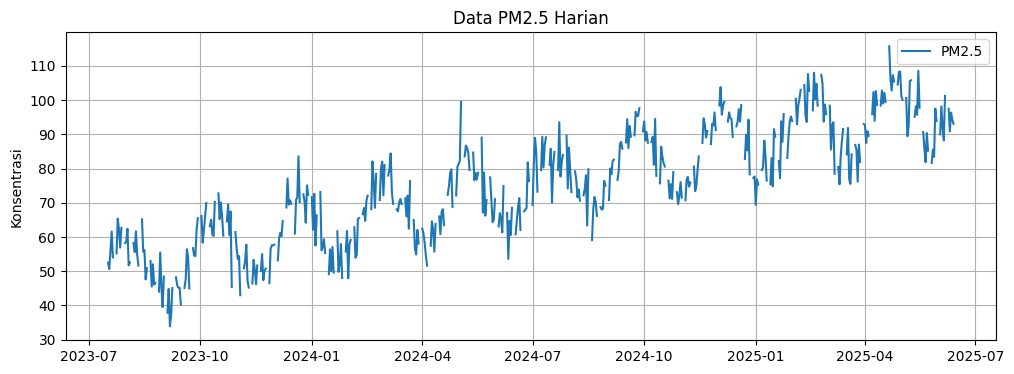

In [3]:
plt.figure(figsize=(12, 4))
plt.plot(df['PM2.5'], label='PM2.5')
plt.title('Data PM2.5 Harian')
plt.ylabel('Konsentrasi')
plt.grid(True)
plt.legend()
plt.show()


Grafik di atas menunjukkan data harian konsentrasi PM2.5 selama periode dari pertengahan tahun 2023 hingga pertengahan 2025. Terlihat bahwa pola PM2.5 cenderung meningkat secara bertahap dari waktu ke waktu, dengan fluktuasi musiman yang berulang kemungkinan menunjukkan adanya pola mingguan atau bulanan. Meskipun terdapat beberapa lonjakan ekstrem, secara umum tren jangka panjang tampak naik, yang menandakan adanya potensi peningkatan polusi udara dari waktu ke waktu di lokasi yang diamati.


# **Uji Stasioneritas**

In [4]:
result = adfuller(df['PM2.5'].dropna())
print('ADF Statistic:', result[0])
print('p-value:', result[1])

if result[1] > 0.05:
    print("Data tidak stasioner, menggunakan differencing (d=1)")
    d = 1
else:
    print("Data sudah stasioner (d=0)")
    d = 0


ADF Statistic: -2.4418637696396983
p-value: 0.13026749433192408
Data tidak stasioner, menggunakan differencing (d=1)


Karena p-value > 0.05, maka kita gagal menolak hipotesis nol yang menyatakan bahwa data memiliki akar unit (yaitu tidak stasioner).
Oleh karena itu, kita perlu melakukan differencing (d=1) agar data menjadi stasioner.

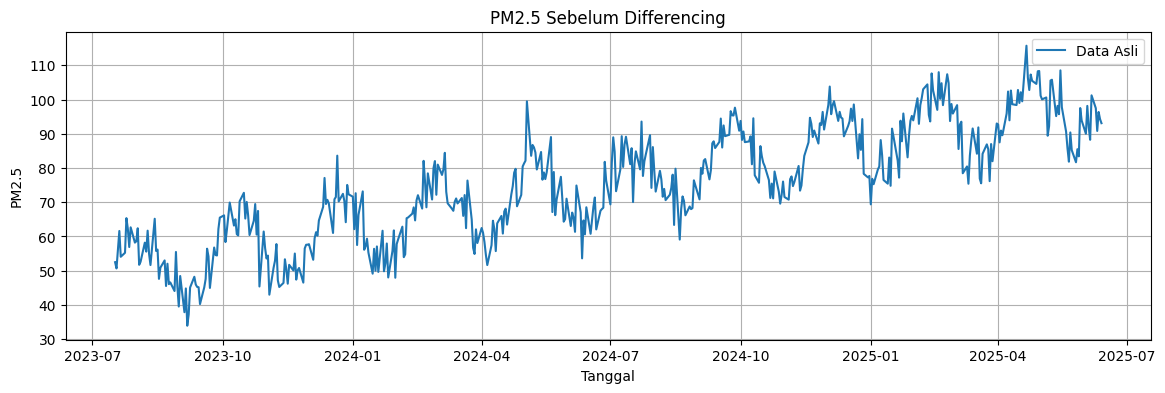

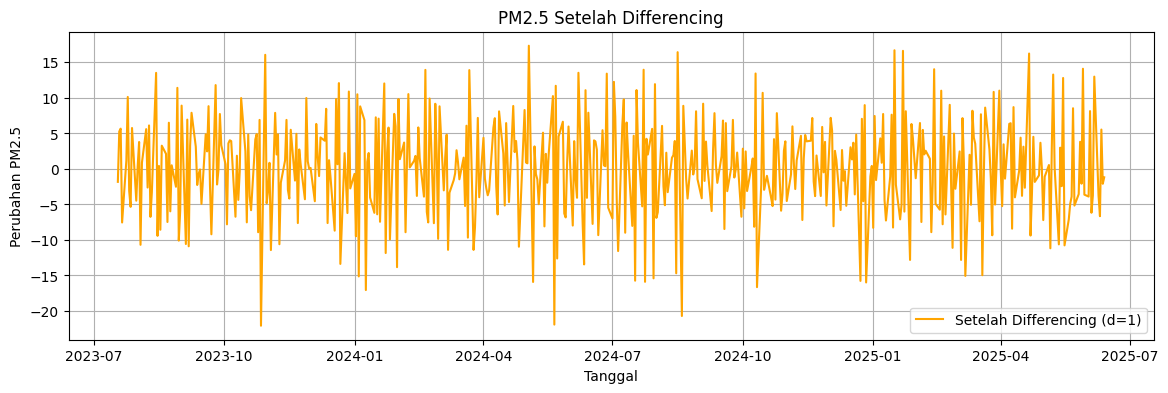

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data dengan parsing tanggal
df = pd.read_csv('/content/data_kualitas_udara_500hari.csv', parse_dates=['Tanggal'], index_col='Tanggal')

# Differencing
df['PM2.5_diff'] = df['PM2.5'].diff()

# Plot sebelum differencing
plt.figure(figsize=(14, 4))
plt.plot(df['PM2.5'], label='Data Asli')
plt.title('PM2.5 Sebelum Differencing')
plt.xlabel('Tanggal')
plt.ylabel('PM2.5')
plt.legend()
plt.grid(True)
plt.show()

# Plot setelah differencing
plt.figure(figsize=(14, 4))
plt.plot(df['PM2.5_diff'], color='orange', label='Setelah Differencing (d=1)')
plt.title('PM2.5 Setelah Differencing')
plt.xlabel('Tanggal')
plt.ylabel('Perubahan PM2.5')
plt.legend()
plt.grid(True)
plt.show()


# **Plot ACF dan PACF**

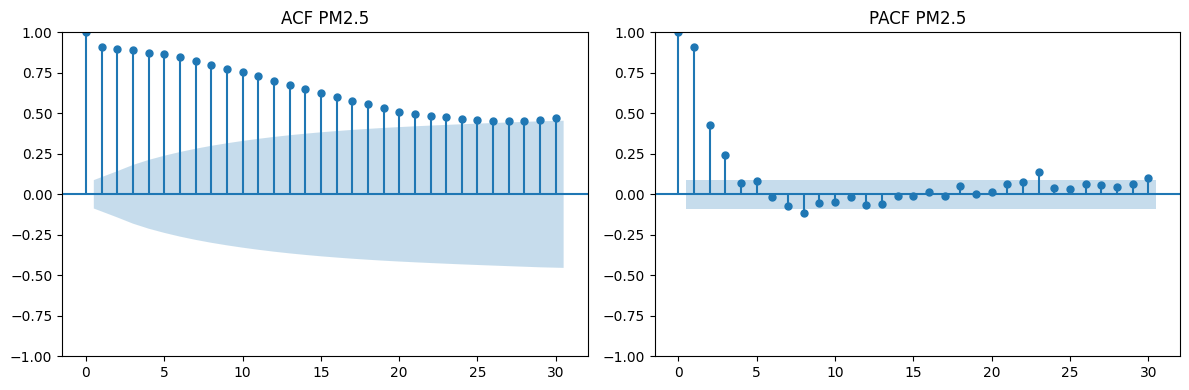

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(df['PM2.5'].dropna(), lags=30, ax=axes[0])
plot_pacf(df['PM2.5'].dropna(), lags=30, ax=axes[1])
axes[0].set_title("ACF PM2.5")
axes[1].set_title("PACF PM2.5")
plt.tight_layout()
plt.show()


Grafik ACF menunjukkan bahwa nilai autokorelasi menurun secara perlahan dan signifikan hingga lag ke-30. Ini adalah pola khas dari data non-stasioner, karena autokorelasi tidak langsung turun ke nol atau melintasi batas signifikansi. Fenomena ini mengonfirmasi hasil uji ADF sebelumnya bahwa data memang tidak stasioner, dan mendukung keputusan untuk menggunakan differencing (d = 1) pada model.

Grafik PACF menunjukkan adanya spike signifikan pada lag 1, 2, dan 3, kemudian turun dan berada dalam batas signifikansi. Ini mengindikasikan bahwa komponen autoregressive (AR) dapat dimasukkan pada model. Dari sini, kita dapat menyimpulkan bahwa AR(1) atau AR(2) bisa menjadi kandidat kuat.


In [6]:
model = SARIMAX(df['PM2.5'],
                order=(1, d, 1),
                seasonal_order=(1, 1, 1, 7))  # Musiman mingguan

model_fit = model.fit(disp=False)

# Tampilkan hasil model
print("📋 SARIMAX Result Summary:")
print(model_fit.summary())


📋 SARIMAX Result Summary:
                                     SARIMAX Results                                     
Dep. Variable:                             PM2.5   No. Observations:                  698
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood               -1588.465
Date:                           Mon, 16 Jun 2025   AIC                           3186.931
Time:                                   05:19:08   BIC                           3209.614
Sample:                               07-17-2023   HQIC                          3195.705
                                    - 06-13-2025                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1539      0.082     -1.871      0.061      -0.315       0.007
ma.L1         -0.

Ringkasan hasil model SARIMAX(1,1,1)(1,1,1,7) menunjukkan bahwa sebagian besar parameter model signifikan (nilai *p-value* < 0.05), kecuali AR(1) yang mendekati tidak signifikan. Nilai AIC (3186.931), BIC (3209.614), dan HQIC (3195.705) relatif rendah, mengindikasikan model cukup baik. Uji diagnostik seperti *Ljung-Box* dan *Heteroskedastisitas* menunjukkan bahwa residual model bersifat acak dan tidak ada autokorelasi yang signifikan. Selain itu, model ini berhasil menangkap pola musiman mingguan (7 hari) dalam data PM2.5.


# **Diagnostik Residual**

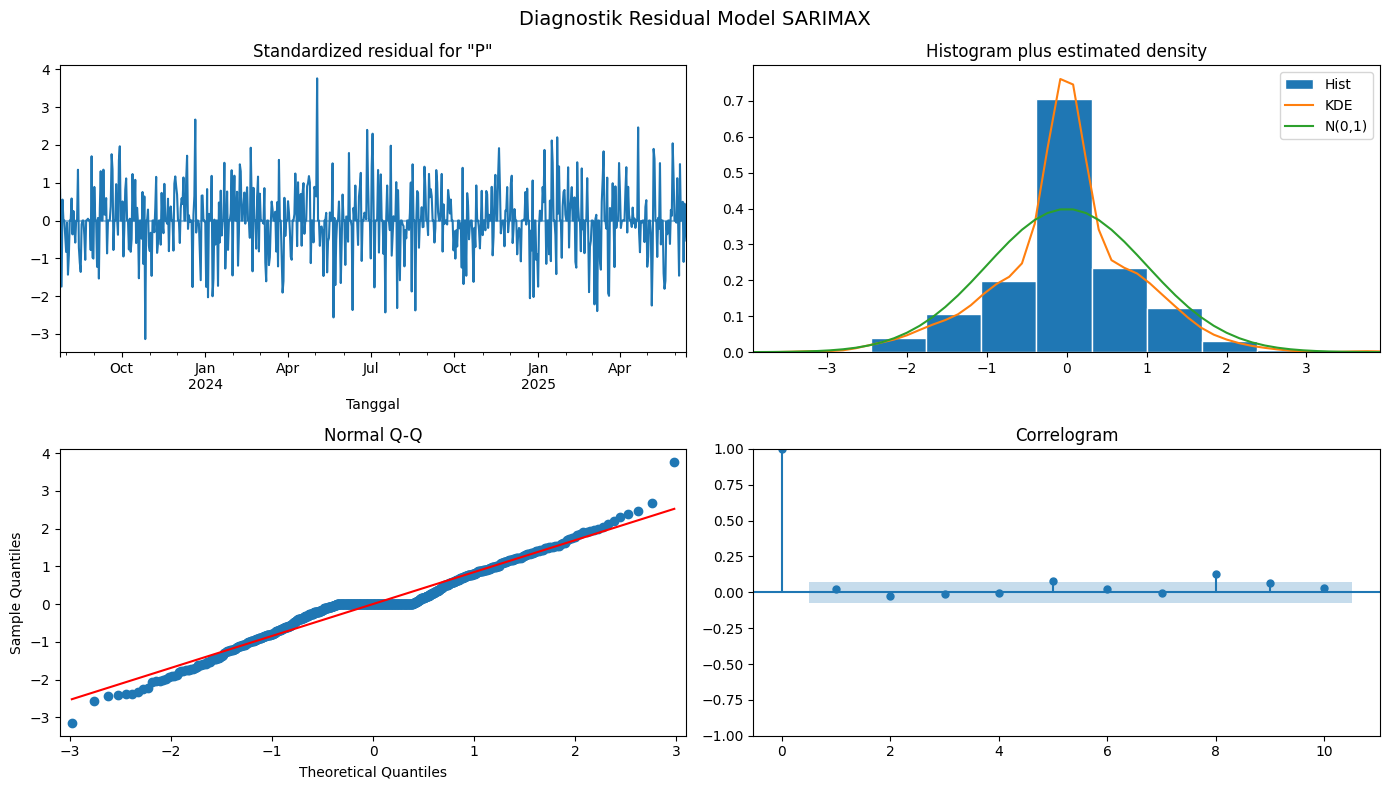

In [7]:
model_fit.plot_diagnostics(figsize=(14, 8))
plt.suptitle('Diagnostik Residual Model SARIMAX', fontsize=14)
plt.tight_layout()
plt.show()


Gambar di atas menunjukkan diagnostik residual model SARIMAX. Residual terdistribusi acak di sekitar nol (plot kiri atas), menunjukkan tidak ada pola yang tersisa. Histogram dan Q-Q plot (kanan atas dan kiri bawah) menunjukkan residual mendekati distribusi normal. Sementara itu, correlogram (kanan bawah) menunjukkan tidak ada autokorelasi yang signifikan. Artinya, model sudah cukup baik, residual bersifat white noise, dan model layak digunakan untuk prediksi.


# **Prediksi 30 Hari ke Depan**

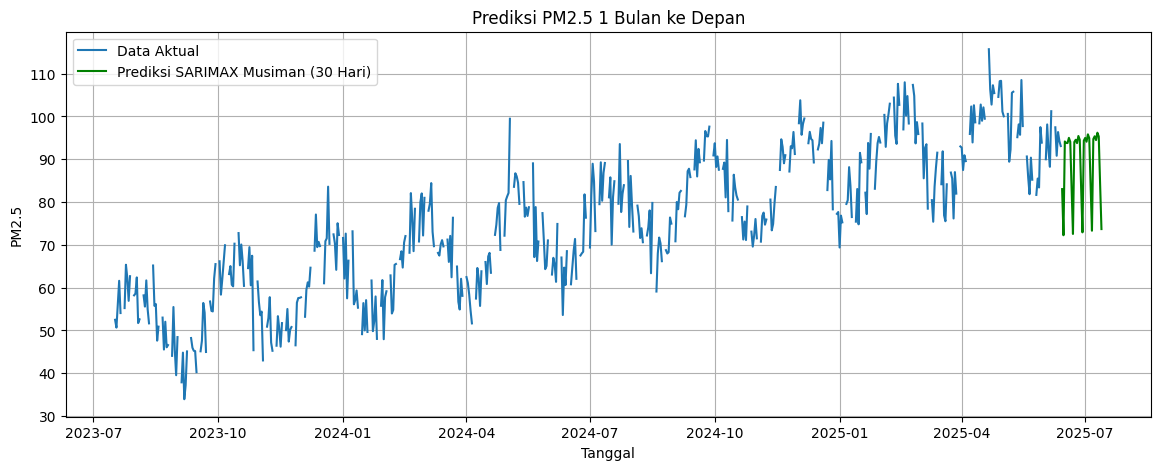

In [8]:
forecast = model_fit.forecast(steps=30)
forecast.index = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=30)

# Plot hasil
plt.figure(figsize=(14, 5))
plt.plot(df['PM2.5'], label='Data Aktual')
plt.plot(forecast, label='Prediksi SARIMAX Musiman (30 Hari)', color='green')
plt.title('Prediksi PM2.5 1 Bulan ke Depan')
plt.xlabel('Tanggal')
plt.ylabel('PM2.5')
plt.grid(True)
plt.legend()
plt.show()


Gambar di atas menunjukkan hasil prediksi kualitas udara (PM2.5) untuk 30 hari ke depan menggunakan model **SARIMAX musiman**. Garis biru merepresentasikan data historis PM2.5 selama lebih dari satu tahun terakhir, sedangkan garis hijau menunjukkan hasil prediksi dari model SARIMAX. Dari grafik tersebut terlihat bahwa model dapat menangkap pola musiman dan tren historis yang terjadi sebelumnya, dan memproyeksikan nilai PM2.5 mendatang dengan pola yang cenderung fluktuatif namun stabil. Hal ini menunjukkan bahwa model SARIMAX mampu memberikan gambaran prediksi yang realistis dan mempertimbangkan unsur musiman dalam data. Model ini cocok digunakan karena data memiliki pola berulang tahunan atau bulanan yang signifikan.



# **Data Prediksi**

In [9]:
print("Prediksi PM2.5 Selama 30 Hari ke Depan:")
print(forecast)


Prediksi PM2.5 Selama 30 Hari ke Depan:
2025-06-14    83.026805
2025-06-15    72.241149
2025-06-16    94.161773
2025-06-17    93.813747
2025-06-18    93.789927
2025-06-19    95.004909
2025-06-20    94.088130
2025-06-21    83.128736
2025-06-22    72.545502
2025-06-23    94.038157
2025-06-24    94.553194
2025-06-25    93.772831
2025-06-26    95.436705
2025-06-27    94.555637
2025-06-28    83.474570
2025-06-29    72.918818
2025-06-30    94.353368
2025-07-01    94.985582
2025-07-02    94.102504
2025-07-03    95.827324
2025-07-04    94.951104
2025-07-05    83.853517
2025-07-06    73.301497
2025-07-07    94.728158
2025-07-08    95.376281
2025-07-09    94.479258
2025-07-10    96.212352
2025-07-11    95.336790
2025-07-12    84.236961
2025-07-13    73.685447
Freq: D, Name: predicted_mean, dtype: float64


* Rentang nilai prediksi: dari 72.24 μg/m³ hingga 96.21 μg/m³

* Rata-rata prediksi (visual): berada di kisaran 85–95 μg/m³

* Hari dengan prediksi terendah: 2025-06-15 dan 2025-06-29 (sekitar 72 μg/m³)

* Hari dengan prediksi tertinggi: 2025-07-10 (96.21 μg/m³)

Kesimpulan:
Prediksi menunjukkan bahwa kualitas udara akan berada pada tingkat “tidak sehat” selama sebagian besar 30 hari ke depan, dengan hanya beberapa hari yang menunjukkan sedikit perbaikan. Hal ini mengindikasikan perlunya kewaspadaan dan intervensi terhadap sumber polusi selama periode tersebut.